In [1]:
import os
import pickle

import equinox as eqx
import jax
import jax.numpy as jnp
import jax.random as jrandom
import matplotlib.pyplot as plt
import numpy as np
import optax
import pandas as pd
from sigformer.hedger import DeepHedger, SigHedger
from sigformer.hedger.delta_hedger import HestonDeltaHedger, RBergomiDeltaHedger  # noqa
from sigformer.instruments.derivative import EuropeanOption, VarianceSwap
from sigformer.instruments.primary import RoughBergomiStock
from sigformer.loss import BaseCriterion
from tqdm import tqdm

### Load data

In [2]:
root_path = "../data/spx/"
spx_file = "SP500.csv"
vix_file = "VIXCLS.csv"
calibrated_file = "calibrated.pkl"

In [3]:
# VIX
df_vix = pd.read_csv(os.path.join(root_path, vix_file))
# SPX
df_spx = pd.read_csv(os.path.join(root_path, spx_file))

In [4]:
df_vix.head()

,DATE,VIXCLS
0,2022-01-03,16.6
1,2022-01-04,16.91
2,2022-01-05,19.73
3,2022-01-06,19.61
4,2022-01-07,18.76


In [5]:
df_spx.head()

,DATE,SP500
0,2022-01-03,4796.56
1,2022-01-04,4793.54
2,2022-01-05,4700.58
3,2022-01-06,4696.05
4,2022-01-07,4677.03


In [6]:
df_vix = df_vix.rename(columns={"VIXCLS": "VIX"})
df_spx = df_spx.rename(columns={"SP500": "SPX"})

df_vix.DATE = pd.to_datetime(df_vix.DATE)
df_vix.VIX = pd.to_numeric(df_vix.VIX, errors="coerce")

df_spx.DATE = pd.to_datetime(df_spx.DATE)
df_spx.SPX = pd.to_numeric(df_spx.SPX, errors="coerce")

In [7]:
df_spx_vix = pd.merge(df_spx, df_vix)

## Hedging given the calibrated parameters

In [8]:
with open(os.path.join(root_path, calibrated_file), "rb") as f:
    calibrated_params = pickle.load(f)

In [9]:
# SigHedger
model_dim = 3
n_attn_heads = 12
n_attn_blocks = 5

# traing
n_train_paths = 1000
n_valid_paths = 1000
n_epochs = 1000
lr = 1e-4

n_test_paths = 5_000
seed = 123
inputs = ["LogMoneyness", "Volatility"]

In [10]:
key = jrandom.PRNGKey(seed)
model_key, train_key, valid_key, test_key = jrandom.split(key, 4)

In [11]:
class ForwardVariance(VarianceSwap):
    def __init__(
        self, underlier, maturity: float = 45.0 / 356, strike: float = 0.04
    ) -> None:
        super().__init__(underlier, maturity, strike)

    def price(self, input):
        forward_variance = input["forward_variance"]
        return forward_variance

In [12]:
class QuadraticLoss(BaseCriterion):

    p0: float

    def __init__(self, p0) -> None:
        super().__init__()
        self.p0 = p0

    def __call__(self, input, target):
        return jnp.mean(jnp.square(input - target + self.p0))

In [13]:
for month in range(1, 13):
    params = calibrated_params[month]

    hurst = params["hurst"]
    rho = params["rho"]
    eta = params["eta"]
    xi = params["xi_sqrt"] ** 2
    cost = (0.0,)
    dt = 1.0 / 365
    forward_offset = 15.0 / 356
    T = 30.0 / 365
    S0 = K = df_spx_vix[df_spx_vix.DATE.dt.month == month]["SPX"].to_numpy()[0]

    print(f"Load calirated params \n \t {params} \n")
    print(f"Initial spot S0 ={S0}")

    stock = RoughBergomiStock(
        hurst=hurst,
        rho=rho,
        xi=xi,
        eta=eta,
        cost=cost,
        dt=dt,
        forward_offset=forward_offset,
    )
    init_state = (S0, stock.xi, None)

    derivative = EuropeanOption(
        underlier=stock,
        call=True,
        strike=K,
        maturity=T,
    )

    forward_variance = ForwardVariance(stock, maturity=T)
    hedge = [derivative, forward_variance]

    payoff_fn = lambda key: derivative.payoff(rng_key=key, init_state=init_state)
    payoff = jax.vmap(payoff_fn)(jrandom.split(test_key, n_test_paths))
    p0 = jnp.mean(payoff)
    loss_fn = QuadraticLoss(p0=p0)
    print(f"p0: {p0.item():.3f}")

    model = SigHedger(
        derivative=derivative,
        inputs=inputs,
        hedge=hedge,
        criterion=QuadraticLoss(p0=p0),
        model_dim=model_dim,
        n_attn_heads=n_attn_heads,
        n_attn_blocks=n_attn_blocks,
        rng_key=model_key,
    )

    optimizer = optax.adam(learning_rate=lr)
    opt_state = optimizer.init(eqx.filter(model, eqx.is_array))

    @eqx.filter_value_and_grad
    def compute_loss(model: SigHedger, n_simulate_paths, rng_key):
        return model.compute_loss(
            init_state=init_state,
            n_paths=n_simulate_paths,
            rng_key=rng_key,
        )

    @eqx.filter_jit
    def make_step(model: SigHedger, opt_state, n_simulate_paths, rng_key):

        loss_value, grads = compute_loss(model, n_simulate_paths, rng_key)
        updates, opt_state = optimizer.update(grads, opt_state, model)
        model = eqx.apply_updates(model, updates)
        return model, opt_state, loss_value

    valid_keys = jrandom.split(valid_key, n_valid_paths)
    valid_data = jax.vmap(
        lambda key: derivative.simulate(rng_key=key, init_state=init_state)
    )(valid_keys)

    @eqx.filter_jit
    def validate(model: SigHedger, valid_data):
        portfolio, payoff = model.compute_pnl(
            rng_key=None,
            n_paths=n_valid_paths,
            simulated_data=valid_data,
            return_portfolio_and_payoff=True,
        )
        return model.criterion(portfolio, payoff)

    progress = tqdm(range(n_epochs), desc=f"Month={month}")
    for i in progress:

        model, opt_state, loss_value = make_step(
            model,
            opt_state,
            n_simulate_paths=n_train_paths,
            rng_key=jrandom.fold_in(train_key, i),
        )

        if i % 20 == 0:
            valid_model = eqx.tree_inference(model, True)

            # compute validate loss
            valid_loss = validate(valid_model, valid_data)

    model = eqx.tree_inference(model, True)
    model_file = f"../checkpoint/model_month_{month}.eqx"
    eqx.tree_serialise_leaves(model_file, model)

Load calirated params 
 	 {'eta': array(2.2667425, dtype=float32), 'hurst': array(0.07116599, dtype=float32), 'rho': array(-0.8565923, dtype=float32), 'xi_sqrt': array(0.0501667, dtype=float32)} 

Initial spot S0 =4796.56
p0: 23.583


Month=1: 100%|██████████| 1000/1000 [02:43<00:00,  6.12it/s]


Load calirated params 
 	 {'eta': array(2.2840803, dtype=float32), 'hurst': array(0.07239809, dtype=float32), 'rho': array(-0.8430177, dtype=float32), 'xi_sqrt': array(0.05022182, dtype=float32)} 

Initial spot S0 =4546.54
p0: 22.388


Month=2: 100%|██████████| 1000/1000 [02:42<00:00,  6.15it/s]


Load calirated params 
 	 {'eta': array(2.5070953, dtype=float32), 'hurst': array(0.05068801, dtype=float32), 'rho': array(-0.7581486, dtype=float32), 'xi_sqrt': array(0.38287702, dtype=float32)} 

Initial spot S0 =4306.26
p0: 161.950


Month=3: 100%|██████████| 1000/1000 [02:42<00:00,  6.17it/s]


Load calirated params 
 	 {'eta': array(2.2346134, dtype=float32), 'hurst': array(0.0511454, dtype=float32), 'rho': array(-0.8372275, dtype=float32), 'xi_sqrt': array(0.05034192, dtype=float32)} 

Initial spot S0 =4545.86
p0: 22.969


Month=4: 100%|██████████| 1000/1000 [02:41<00:00,  6.18it/s]


Load calirated params 
 	 {'eta': array(2.2072177, dtype=float32), 'hurst': array(0.06383608, dtype=float32), 'rho': array(-0.85115665, dtype=float32), 'xi_sqrt': array(0.2711833, dtype=float32)} 

Initial spot S0 =4155.38
p0: 110.823


Month=5: 100%|██████████| 1000/1000 [02:41<00:00,  6.19it/s]


Load calirated params 
 	 {'eta': array(3.1368206, dtype=float32), 'hurst': array(0.02572006, dtype=float32), 'rho': array(-0.7487836, dtype=float32), 'xi_sqrt': array(0.47113323, dtype=float32)} 

Initial spot S0 =4101.23
p0: 171.610


Month=6: 100%|██████████| 1000/1000 [02:42<00:00,  6.14it/s]


Load calirated params 
 	 {'eta': array(2.319245, dtype=float32), 'hurst': array(0.06869617, dtype=float32), 'rho': array(-0.8412051, dtype=float32), 'xi_sqrt': array(0.05028014, dtype=float32)} 

Initial spot S0 =3825.33
p0: 18.863


Month=7: 100%|██████████| 1000/1000 [02:43<00:00,  6.13it/s]


Load calirated params 
 	 {'eta': array(2.2069018, dtype=float32), 'hurst': array(0.05163295, dtype=float32), 'rho': array(-0.8056911, dtype=float32), 'xi_sqrt': array(0.17182197, dtype=float32)} 

Initial spot S0 =4118.63
p0: 71.246


Month=8: 100%|██████████| 1000/1000 [02:42<00:00,  6.17it/s]


Load calirated params 
 	 {'eta': array(2.2644217, dtype=float32), 'hurst': array(0.09229718, dtype=float32), 'rho': array(-0.8372041, dtype=float32), 'xi_sqrt': array(0.05011558, dtype=float32)} 

Initial spot S0 =3966.85
p0: 19.285


Month=9: 100%|██████████| 1000/1000 [02:43<00:00,  6.10it/s]


Load calirated params 
 	 {'eta': array(1.9532868, dtype=float32), 'hurst': array(0.02511391, dtype=float32), 'rho': array(-0.73340106, dtype=float32), 'xi_sqrt': array(0.06674874, dtype=float32)} 

Initial spot S0 =3678.43
p0: 26.074


Month=10: 100%|██████████| 1000/1000 [02:43<00:00,  6.11it/s]


Load calirated params 
 	 {'eta': array(1.9764926, dtype=float32), 'hurst': array(0.0668933, dtype=float32), 'rho': array(-0.82157904, dtype=float32), 'xi_sqrt': array(0.25470775, dtype=float32)} 

Initial spot S0 =3856.1
p0: 98.518


Month=11: 100%|██████████| 1000/1000 [02:43<00:00,  6.12it/s]


Load calirated params 
 	 {'eta': array(2.1945572, dtype=float32), 'hurst': array(0.06761874, dtype=float32), 'rho': array(-0.8346016, dtype=float32), 'xi_sqrt': array(0.05024514, dtype=float32)} 

Initial spot S0 =4076.57
p0: 20.335


Month=12: 100%|██████████| 1000/1000 [02:42<00:00,  6.17it/s]


In [29]:
# make dummy model
stock = RoughBergomiStock(
    hurst=0.1,
    rho=-0.9,
    xi=0.7,
    eta=0.235**2,
    cost=0,
    dt=1.0 / 365,
    forward_offset=15.0 / 365,
)
init_state = (100, stock.xi, None)

derivative = EuropeanOption(
    underlier=stock,
    call=True,
    strike=100,
    maturity=30.0 / 365,
)

forward_variance = ForwardVariance(stock, maturity=30.0 / 365)
hedge = [derivative, forward_variance]

model = SigHedger(
    derivative=derivative,
    inputs=inputs,
    hedge=hedge,
    model_dim=model_dim,
    n_attn_heads=n_attn_heads,
    n_attn_blocks=n_attn_blocks,
    rng_key=model_key,
)

In [30]:
pnl_evolutions = {}
for month in tqdm(range(1, 13)):
    df_month = df_spx_vix[df_spx_vix.DATE.dt.month == month].dropna()
    spx = df_month["SPX"].to_numpy()
    vix = df_month["VIX"].to_numpy()
    moneyness = spx / K
    var_swap = vix / 100
    log_moneyness = jnp.log(jnp.asarray(moneyness, dtype=jnp.float32))
    var_swap = jnp.asarray(var_swap)
    log_moneyness_var_swap = jnp.stack([log_moneyness, var_swap], axis=1)
    model_file = f"../checkpoint/model_month_{month}.eqx"
    model = eqx.tree_deserialise_leaves(model_file, model)
    unit = model.model(log_moneyness_var_swap, key=None)

    # compute
    output = unit[:-1] * jnp.diff(log_moneyness_var_swap, axis=0)
    output = jnp.sum(output, axis=-1)
    output = jnp.cumsum(output, axis=0)
    pnl_evolutions[month] = np.array(output)

100%|██████████| 12/12 [00:38<00:00,  3.18s/it]


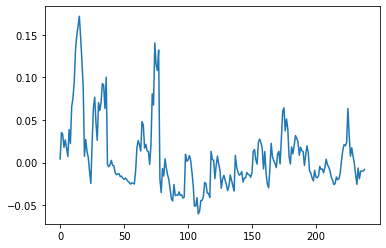

In [15]:
plt.plot(np.concatenate(list(pnl_evolutions.values())))

### Deep hedging

In [39]:
for month in range(1, 13):
    params = calibrated_params[month]

    hurst = params["hurst"]
    rho = params["rho"]
    eta = params["eta"]
    xi = params["xi_sqrt"] ** 2
    cost = (0.0,)
    dt = 1.0 / 365
    forward_offset = 15.0 / 356
    T = 30.0 / 365
    S0 = K = df_spx_vix[df_spx_vix.DATE.dt.month == month]["SPX"].to_numpy()[0]

    print(f"Load calirated params \n \t {params} \n")
    print(f"Initial spot S0 ={S0}")

    stock = RoughBergomiStock(
        hurst=hurst,
        rho=rho,
        xi=xi,
        eta=eta,
        cost=cost,
        dt=dt,
        forward_offset=forward_offset,
    )
    init_state = (S0, stock.xi, None)

    derivative = EuropeanOption(
        underlier=stock,
        call=True,
        strike=K,
        maturity=T,
    )

    forward_variance = ForwardVariance(stock, maturity=T)
    hedge = [derivative, forward_variance]

    payoff_fn = lambda key: derivative.payoff(rng_key=key, init_state=init_state)
    payoff = jax.vmap(payoff_fn)(jrandom.split(test_key, n_test_paths))
    p0 = jnp.mean(payoff)
    loss_fn = QuadraticLoss(p0=p0)
    print(f"p0: {p0.item():.3f}")

    model = DeepHedger(
        derivative=derivative,
        inputs=inputs,
        hedge=hedge,
        criterion=QuadraticLoss(p0=p0),
        recur_type="Recur",
        rng_key=model_key,
    )

    optimizer = optax.adam(learning_rate=lr)
    opt_state = optimizer.init(eqx.filter(model, eqx.is_array))

    @eqx.filter_value_and_grad
    def compute_loss(model: DeepHedger, n_simulate_paths, rng_key):  # noqa
        return model.compute_loss(
            init_state=init_state,
            n_paths=n_simulate_paths,
            rng_key=rng_key,
        )

    @eqx.filter_jit
    def make_step(model: DeepHedger, opt_state, n_simulate_paths, rng_key):  # noqa

        loss_value, grads = compute_loss(model, n_simulate_paths, rng_key)
        updates, opt_state = optimizer.update(grads, opt_state, model)
        model = eqx.apply_updates(model, updates)
        return model, opt_state, loss_value

    valid_keys = jrandom.split(valid_key, n_valid_paths)
    valid_data = jax.vmap(
        lambda key: derivative.simulate(rng_key=key, init_state=init_state)
    )(valid_keys)

    @eqx.filter_jit
    def validate(model: SigHedger, valid_data):
        portfolio, payoff = model.compute_pnl(
            rng_key=None,
            n_paths=n_valid_paths,
            simulated_data=valid_data,
            return_portfolio_and_payoff=True,
        )
        return model.criterion(portfolio, payoff)

    progress = tqdm(range(n_epochs * 3), desc=f"Month={month}")  #
    for i in progress:

        model, opt_state, loss_value = make_step(
            model,
            opt_state,
            n_simulate_paths=n_train_paths,
            rng_key=jrandom.fold_in(train_key, i),
        )

        if i % 20 == 0:
            valid_model = eqx.tree_inference(model, True)

            # compute validate loss
            valid_loss = validate(valid_model, valid_data)

    model = eqx.tree_inference(model, True)
    model_file = f"../checkpoint/deephedger_month_{month}.eqx"
    eqx.tree_serialise_leaves(model_file, model)

Load calirated params 
 	 {'eta': array(2.2667425, dtype=float32), 'hurst': array(0.07116599, dtype=float32), 'rho': array(-0.8565923, dtype=float32), 'xi_sqrt': array(0.0501667, dtype=float32)} 

Initial spot S0 =4796.56
p0: 23.583


Month=1: 100%|██████████| 3000/3000 [00:34<00:00, 86.85it/s]


Load calirated params 
 	 {'eta': array(2.2840803, dtype=float32), 'hurst': array(0.07239809, dtype=float32), 'rho': array(-0.8430177, dtype=float32), 'xi_sqrt': array(0.05022182, dtype=float32)} 

Initial spot S0 =4546.54
p0: 22.388


Month=2: 100%|██████████| 3000/3000 [00:35<00:00, 85.37it/s]


Load calirated params 
 	 {'eta': array(2.5070953, dtype=float32), 'hurst': array(0.05068801, dtype=float32), 'rho': array(-0.7581486, dtype=float32), 'xi_sqrt': array(0.38287702, dtype=float32)} 

Initial spot S0 =4306.26
p0: 161.950


Month=3: 100%|██████████| 3000/3000 [00:34<00:00, 88.14it/s]


Load calirated params 
 	 {'eta': array(2.2346134, dtype=float32), 'hurst': array(0.0511454, dtype=float32), 'rho': array(-0.8372275, dtype=float32), 'xi_sqrt': array(0.05034192, dtype=float32)} 

Initial spot S0 =4545.86
p0: 22.969


Month=4: 100%|██████████| 3000/3000 [00:34<00:00, 87.86it/s]


Load calirated params 
 	 {'eta': array(2.2072177, dtype=float32), 'hurst': array(0.06383608, dtype=float32), 'rho': array(-0.85115665, dtype=float32), 'xi_sqrt': array(0.2711833, dtype=float32)} 

Initial spot S0 =4155.38
p0: 110.823


Month=5: 100%|██████████| 3000/3000 [00:30<00:00, 97.85it/s] 


Load calirated params 
 	 {'eta': array(3.1368206, dtype=float32), 'hurst': array(0.02572006, dtype=float32), 'rho': array(-0.7487836, dtype=float32), 'xi_sqrt': array(0.47113323, dtype=float32)} 

Initial spot S0 =4101.23
p0: 171.610


Month=6: 100%|██████████| 3000/3000 [00:30<00:00, 99.02it/s] 


Load calirated params 
 	 {'eta': array(2.319245, dtype=float32), 'hurst': array(0.06869617, dtype=float32), 'rho': array(-0.8412051, dtype=float32), 'xi_sqrt': array(0.05028014, dtype=float32)} 

Initial spot S0 =3825.33
p0: 18.863


Month=7: 100%|██████████| 3000/3000 [00:30<00:00, 99.07it/s] 


Load calirated params 
 	 {'eta': array(2.2069018, dtype=float32), 'hurst': array(0.05163295, dtype=float32), 'rho': array(-0.8056911, dtype=float32), 'xi_sqrt': array(0.17182197, dtype=float32)} 

Initial spot S0 =4118.63
p0: 71.246


Month=8: 100%|██████████| 3000/3000 [00:30<00:00, 98.21it/s] 


Load calirated params 
 	 {'eta': array(2.2644217, dtype=float32), 'hurst': array(0.09229718, dtype=float32), 'rho': array(-0.8372041, dtype=float32), 'xi_sqrt': array(0.05011558, dtype=float32)} 

Initial spot S0 =3966.85
p0: 19.285


Month=9: 100%|██████████| 3000/3000 [00:30<00:00, 99.10it/s] 


Load calirated params 
 	 {'eta': array(1.9532868, dtype=float32), 'hurst': array(0.02511391, dtype=float32), 'rho': array(-0.73340106, dtype=float32), 'xi_sqrt': array(0.06674874, dtype=float32)} 

Initial spot S0 =3678.43
p0: 26.074


Month=10: 100%|██████████| 3000/3000 [00:30<00:00, 98.65it/s] 


Load calirated params 
 	 {'eta': array(1.9764926, dtype=float32), 'hurst': array(0.0668933, dtype=float32), 'rho': array(-0.82157904, dtype=float32), 'xi_sqrt': array(0.25470775, dtype=float32)} 

Initial spot S0 =3856.1
p0: 98.518


Month=11: 100%|██████████| 3000/3000 [00:30<00:00, 99.13it/s] 


Load calirated params 
 	 {'eta': array(2.1945572, dtype=float32), 'hurst': array(0.06761874, dtype=float32), 'rho': array(-0.8346016, dtype=float32), 'xi_sqrt': array(0.05024514, dtype=float32)} 

Initial spot S0 =4076.57
p0: 20.335


Month=12: 100%|██████████| 3000/3000 [00:30<00:00, 98.15it/s] 


In [40]:
model = DeepHedger(
    derivative=derivative,
    inputs=inputs,
    hedge=hedge,
    recur_type="Recur",
    rng_key=model_key,
)
deephedger_pnl_evolutions = {}
for month in tqdm(range(1, 13)):
    df_month = df_spx_vix[df_spx_vix.DATE.dt.month == month].dropna()
    spx = df_month["SPX"].to_numpy()
    vix = df_month["VIX"].to_numpy()
    moneyness = spx / K
    var_swap = vix / 100
    log_moneyness = jnp.log(jnp.asarray(moneyness, dtype=jnp.float32))
    var_swap = jnp.asarray(var_swap)
    log_moneyness_var_swap = jnp.stack([log_moneyness, var_swap], axis=1)
    model_file = f"../checkpoint/deephedger_month_{month}.eqx"
    model = eqx.tree_deserialise_leaves(model_file, model)
    unit = model.compute_hedge(
        simulated_data={
            "spot": jnp.array(spx)[None, ...],
            "variance": jnp.array(vix / 100)[None, ...],
        },
        key=None,
    )

    unit = unit[0, ...]

    # compute
    output = unit[:-1] * jnp.diff(log_moneyness_var_swap, axis=0)
    output = jnp.sum(output, axis=-1)
    output = jnp.cumsum(output, axis=0)
    deephedger_pnl_evolutions[month] = np.array(output)

  0%|          | 0/12 [00:00<?, ?it/s]

100%|██████████| 12/12 [00:02<00:00,  4.25it/s]


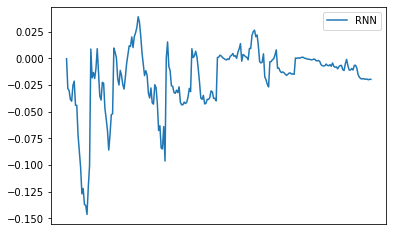

In [41]:
# plt.plot(np.concatenate(list(pnl_evolutions.values())), label="SigFormer")
plt.plot(np.concatenate(list(deephedger_pnl_evolutions.values())), label="RNN")
plt.xticks([])
plt.legend()

In [19]:
df_month = df_spx_vix[df_spx_vix.DATE.dt.month == month].dropna()

In [43]:
import matplotlib as mpl


mpl.rc("figure", dpi=300)
mpl.rc("font", family="Serif", serif=["Times", "Palatino", "serif"], size=18)
mpl.rc("axes", labelsize=10)
mpl.rc("axes", titlesize=12)
mpl.rc("xtick", labelsize=10)
mpl.rc("ytick", labelsize=10)

# Adjust the linewidths for lines and borders
mpl.rc("lines", linewidth=1)
mpl.rc("patch", linewidth=1)

# Customize the grid appearance
mpl.rc("grid", linewidth=0.5)
mpl.rc("grid", linestyle="--")
mpl.rc("grid", alpha=0.7)

# Set the legend font size and frame properties
mpl.rc("legend", fontsize=8)
mpl.rc("legend", frameon=True)
mpl.rc("legend", framealpha=0.7)
mpl.rc("legend", facecolor="white")

In [21]:
spx_2022 = []

for month in tqdm(range(1, 13)):
    df_month = df_spx_vix[df_spx_vix.DATE.dt.month == month].dropna()
    spx = df_month["SPX"].to_numpy()
    spx_2022.append(spx)

spx_2022 = np.concatenate(spx_2022)

100%|██████████| 12/12 [00:00<00:00, 579.88it/s]


### Perfect Hedge

In [22]:
delta_pnl_evolutions = {}
for month in tqdm(range(1, 13)):

    params = calibrated_params[month]
    hurst = params["hurst"]
    rho = params["rho"]
    eta = params["eta"]
    xi = params["xi_sqrt"] ** 2
    cost = (0.0,)
    dt = 1.0 / 365
    forward_offset = 15.0 / 356
    T = 30.0 / 365
    S0 = K = df_spx_vix[df_spx_vix.DATE.dt.month == month]["SPX"].to_numpy()[0]

    print(f"Load calirated params \n \t {params} \n")
    print(f"Initial spot S0 ={S0}")

    stock = RoughBergomiStock(
        hurst=hurst,
        rho=rho,
        xi=xi,
        eta=eta,
        cost=cost,
        dt=dt,
        forward_offset=forward_offset,
    )
    init_state = (S0, stock.xi, None)

    derivative = EuropeanOption(
        underlier=stock,
        call=True,
        strike=K,
        maturity=T,
    )

    df_month = df_spx_vix[df_spx_vix.DATE.dt.month == month].dropna()
    spx = df_month["SPX"].to_numpy()
    vix = df_month["VIX"].to_numpy()
    moneyness = spx / K
    var_swap = vix / 100
    log_moneyness = jnp.log(jnp.asarray(moneyness, dtype=jnp.float32))
    var_swap = jnp.asarray(var_swap)
    log_moneyness_var_swap = jnp.stack([log_moneyness, var_swap], axis=1)

    delta_hedger = RBergomiDeltaHedger(derivative)
    unit = delta_hedger.compute_hedge(
        simulated_data={
            "spot": jnp.array(spx)[None, ...],
            "variance": jnp.sqrt(jnp.array(vix / 100)[None, ...]),
            "forward_variance": jnp.sqrt(jnp.array(vix / 100)[None, ...]),
        },
        key=jrandom.PRNGKey(0),
    )
    unit = unit[0, ...]

    # compute
    output = unit[:-1] * jnp.diff(log_moneyness_var_swap, axis=0)
    output = jnp.sum(output, axis=-1)
    output = jnp.cumsum(output, axis=0)
    delta_pnl_evolutions[month] = np.array(output)

  0%|          | 0/12 [00:00<?, ?it/s]

Load calirated params 
 	 {'eta': array(2.2667425, dtype=float32), 'hurst': array(0.07116599, dtype=float32), 'rho': array(-0.8565923, dtype=float32), 'xi_sqrt': array(0.0501667, dtype=float32)} 

Initial spot S0 =4796.56


  8%|▊         | 1/12 [00:13<02:32, 13.88s/it]

Load calirated params 
 	 {'eta': array(2.2840803, dtype=float32), 'hurst': array(0.07239809, dtype=float32), 'rho': array(-0.8430177, dtype=float32), 'xi_sqrt': array(0.05022182, dtype=float32)} 

Initial spot S0 =4546.54


 17%|█▋        | 2/12 [00:26<02:13, 13.32s/it]

Load calirated params 
 	 {'eta': array(2.5070953, dtype=float32), 'hurst': array(0.05068801, dtype=float32), 'rho': array(-0.7581486, dtype=float32), 'xi_sqrt': array(0.38287702, dtype=float32)} 

Initial spot S0 =4306.26


 25%|██▌       | 3/12 [00:41<02:05, 13.98s/it]

Load calirated params 
 	 {'eta': array(2.2346134, dtype=float32), 'hurst': array(0.0511454, dtype=float32), 'rho': array(-0.8372275, dtype=float32), 'xi_sqrt': array(0.05034192, dtype=float32)} 

Initial spot S0 =4545.86


 33%|███▎      | 4/12 [00:55<01:50, 13.79s/it]

Load calirated params 
 	 {'eta': array(2.2072177, dtype=float32), 'hurst': array(0.06383608, dtype=float32), 'rho': array(-0.85115665, dtype=float32), 'xi_sqrt': array(0.2711833, dtype=float32)} 

Initial spot S0 =4155.38


 42%|████▏     | 5/12 [01:08<01:36, 13.83s/it]

Load calirated params 
 	 {'eta': array(3.1368206, dtype=float32), 'hurst': array(0.02572006, dtype=float32), 'rho': array(-0.7487836, dtype=float32), 'xi_sqrt': array(0.47113323, dtype=float32)} 

Initial spot S0 =4101.23


 50%|█████     | 6/12 [01:22<01:22, 13.82s/it]

Load calirated params 
 	 {'eta': array(2.319245, dtype=float32), 'hurst': array(0.06869617, dtype=float32), 'rho': array(-0.8412051, dtype=float32), 'xi_sqrt': array(0.05028014, dtype=float32)} 

Initial spot S0 =3825.33


 58%|█████▊    | 7/12 [01:36<01:08, 13.69s/it]

Load calirated params 
 	 {'eta': array(2.2069018, dtype=float32), 'hurst': array(0.05163295, dtype=float32), 'rho': array(-0.8056911, dtype=float32), 'xi_sqrt': array(0.17182197, dtype=float32)} 

Initial spot S0 =4118.63


 67%|██████▋   | 8/12 [01:50<00:55, 13.93s/it]

Load calirated params 
 	 {'eta': array(2.2644217, dtype=float32), 'hurst': array(0.09229718, dtype=float32), 'rho': array(-0.8372041, dtype=float32), 'xi_sqrt': array(0.05011558, dtype=float32)} 

Initial spot S0 =3966.85


 75%|███████▌  | 9/12 [02:04<00:41, 13.89s/it]

Load calirated params 
 	 {'eta': array(1.9532868, dtype=float32), 'hurst': array(0.02511391, dtype=float32), 'rho': array(-0.73340106, dtype=float32), 'xi_sqrt': array(0.06674874, dtype=float32)} 

Initial spot S0 =3678.43


 83%|████████▎ | 10/12 [02:18<00:27, 13.88s/it]

Load calirated params 
 	 {'eta': array(1.9764926, dtype=float32), 'hurst': array(0.0668933, dtype=float32), 'rho': array(-0.82157904, dtype=float32), 'xi_sqrt': array(0.25470775, dtype=float32)} 

Initial spot S0 =3856.1


 92%|█████████▏| 11/12 [02:32<00:13, 13.90s/it]

Load calirated params 
 	 {'eta': array(2.1945572, dtype=float32), 'hurst': array(0.06761874, dtype=float32), 'rho': array(-0.8346016, dtype=float32), 'xi_sqrt': array(0.05024514, dtype=float32)} 

Initial spot S0 =4076.57


100%|██████████| 12/12 [02:45<00:00, 13.82s/it]


In [23]:
months = [
    "Jan",
    "Feb",
    "Mar",
    "Apr",
    "May",
    "Jun",
    "Jul",
    "Aug",
    "Sep",
    "Oct",
    "Nov",
    "Dec",
]
index = [0]
for month in range(1, 12):
    a = index[-1] + len(delta_pnl_evolutions[month])
    index.append(a)

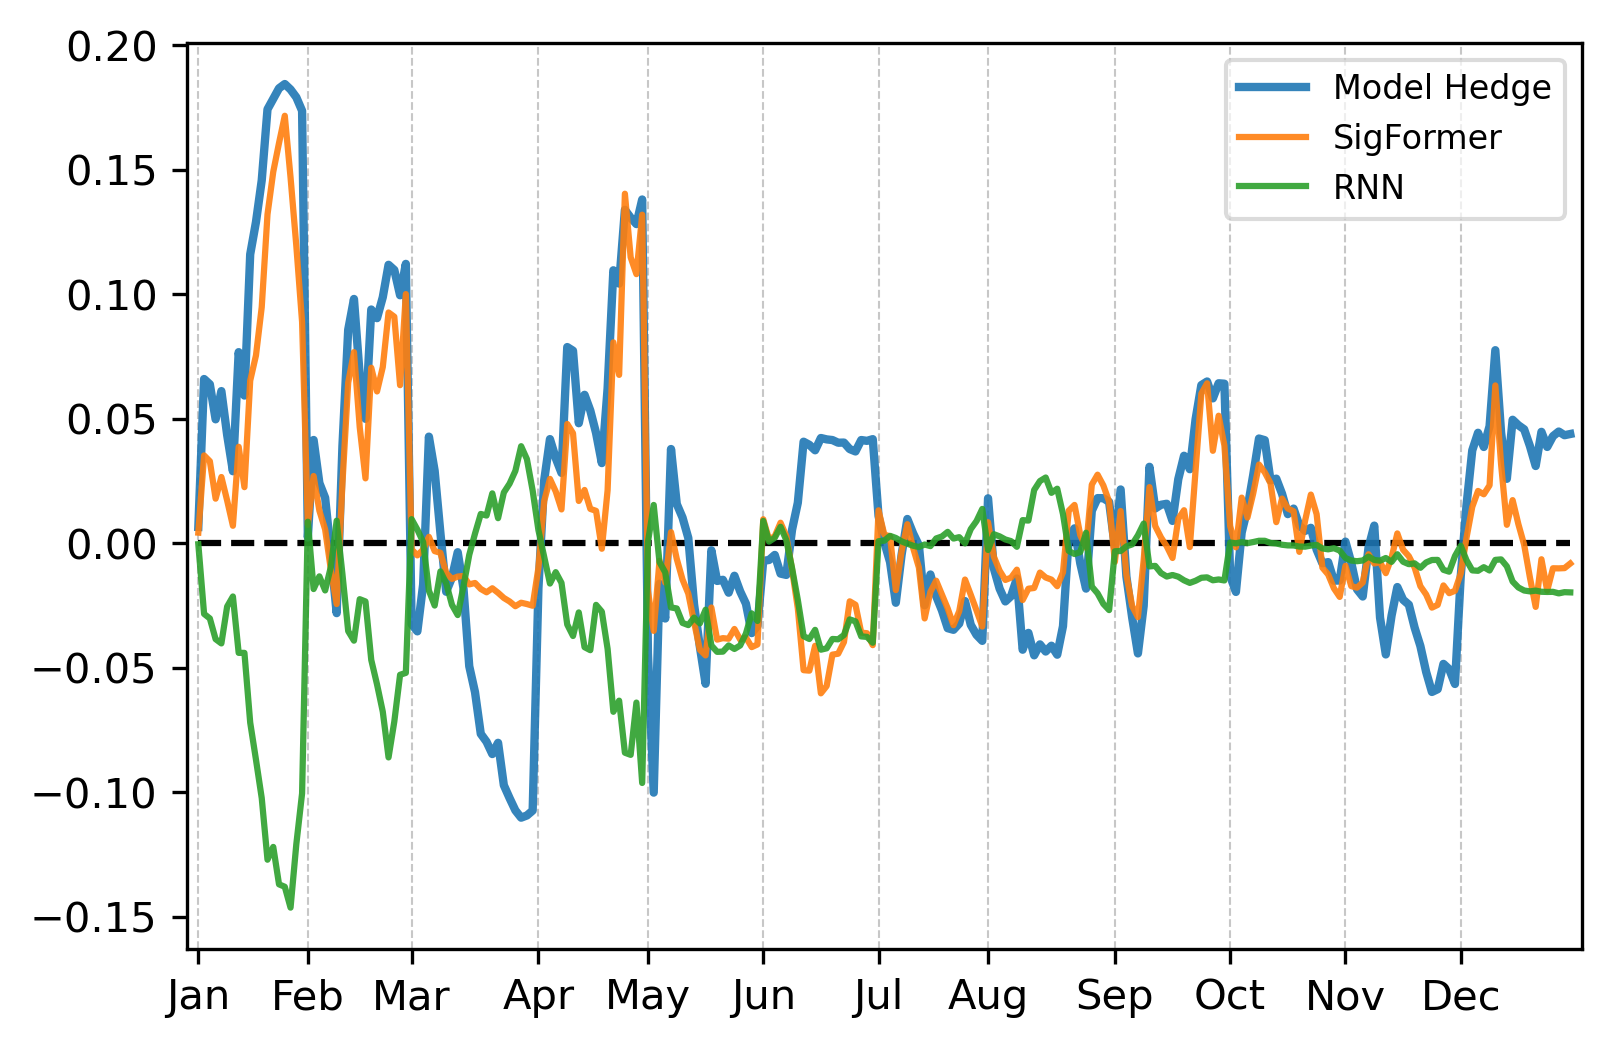

In [49]:
fig, ax1 = plt.subplots(1, 1, figsize=(6, 4))
ax1.plot(
    np.zeros_like(np.concatenate(list(delta_pnl_evolutions.values()))),
    linestyle="--",
    color="black",
    linewidth=1.5,
)
ax1.plot(
    np.concatenate(list(delta_pnl_evolutions.values())) / 100,
    linewidth=2,
    label="Model Hedge",
    alpha=0.9,
)
ax1.plot(
    np.concatenate(list(pnl_evolutions.values())),
    linewidth=1.5,
    label="SigFormer",
    alpha=0.9,
)
ax1.plot(
    np.concatenate(list(deephedger_pnl_evolutions.values())),
    linewidth=1.5,
    label="RNN",
    alpha=0.9,
)
ax1.xaxis.grid(True)
# plt.grid(True)
plt.xticks(ticks=index, labels=months)
plt.xlim(left=-2, right=20 * 12)
plt.legend()

In [45]:
fig.savefig("../output/pnl_evolution.pdf", bbox_inches="tight")